<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [2.0 Process Modeling](https://jckantor.github.io/cbe30338-2021/02.00-Process-Modeling.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.2 Gravity Drained Tank](https://jckantor.github.io/cbe30338-2021/02.02-Gravity-Drained-Tank.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.01-One-Compartment-Pharmacokinetics.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.01-One-Compartment-Pharmacokinetics.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.1 One Compartment Pharmacokinetics

## 2.1.1 Learning Goals

The notebook introduces a single, linear, first-order differential equation in the general form

$$\frac{dx}{dt} = a x + b u$$

as mathematical model to describe the dynamic response of a system to a changing input. 

In any particular application, the **state variable** $x$ corresponds to a process variable such as temperature, pressure, concentration, or position. The **input variable** $u(t)$ corresponds to a changing input such as heater power, flowrate, or valve position. This notebook uses this equation to describe a one-compartment model for a pharmacokinetics in the which the state is the concentration of an antimicrobrial, and the input is a rate of intraveneous administration.

This notebook demonstrates features of this model that can be used in a wide range of process applications:

* Simulate response from a known initial condition.
* Simulate response to a changinig input.



## 2.1.2 Pharamacokinetics

Pharmacokinetics is a branch of pharmacology that studies the fate of chemical species in living organisms. The diverse range of applications includes the administration of drugs and anesthesia in humans. This notebook introduces a one compartment model for pharmacokinetics and shows how it can be used to determine strategies for the intravenous administration of an antimicrobial.

### 2.1.2.1 One-Compartment Model

For the purposes of drug administration, for a one-compartment model of the human body is assumed to consist of a single compartment of a constant volume $V$ containing all the plasma of the body. The plasma is assumed to be sufficiently well mixed that any drug is uniformly distributed with concentration $C(t)$. The drug enters the plasma by direct injection into the plasma at rate $u(t)$. The drug leaves the body as a component of the plasma where $Q$ is the constant plasma clearance rate.

![](./figures/PK-one-compartment.png)

A generic mass balance for a single species is given by

$$\fbox{Rate of Accumulation} = \fbox{Inflow} - \fbox{Outflow} + \fbox{Production by reaction} - \fbox{Consumption by reaction}$$

Assuming the drug is neither produced or consumed by reaction in the body, this generic mass balance can be translated to differential equation

$$\begin{align*}
\underbrace{\fbox{Rate of Accumulation}}_{V \frac{dC}{dt}} & = \underbrace{\fbox{Inflow}}_{u(t)} - \underbrace{\fbox{Outflow}}_{Q C} + \underbrace{\fbox{Production by reaction}}_0 - \underbrace{\fbox{Consumption by reaction}}_0
\end{align*}$$

or, summarizing,

$$V \frac{dC}{dt} = u(t) - Q C(t)$$

This model is characterized by two parameters, the plasma volume $V$ and the clearance rate $Q$.

### 2.1.2.2 Antimicrobials

Let's consider the administration of an antimicrobial to a patient. Concentration $C(t)$ refers to the concentration of the antibiotic in blood plasma in units of [mg/L or $\mu$g/mL]. There are two concentration levels of interest in the medical use of an antimicrobrial:

**Minimum Inhibitory Concentration (MIC)** The minimum concentration of the antibiotic that prevents visible growth of a particular microorganism after overnight incubation. This is generally not enough to kill the microorganism, only enough to prevent further growth.

**Minimum Bactricidal Concentration (MBC)** The lowest concentration of the antimicrobrial that prevents the growth of the microorganism after subculture to antimicrobrial-free media. MBC is generally the concentration needed "kill" the microorganism.

Extended exposure to an antimicrobrial at levels below MBC leads to [antimicrobrial resistance](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4378521/).

### 2.1.2.3 What questions can we ask and answer with this model?

There are multiple reasons to create mathematical models. In research and development, for example, a mathematical model forms a testable hypothesis of one's understanding of a system. The model guides the design of experiments to either validate or falsify the assumptions incorporated in the model.  

In the present context of control systems, a model is used to answer operating questions. In pharmacokinetics, for example, the operational questions might include:

* What values for the parameters $V$ and $Q$ provide accurate predictions of system response?
* How long will it take to clear the antimicrobial from the body?
* What rate of antimicrobial addition is required to achieve the minimum bactricidal concentration?
* If doses are administered periodically, how large should each dose be, and how frequently should the doses be administered?

Questions like these can be answered through simulation, regression to experimental data, and mathematical analysis. We'll explore several of these techniques below.

* Simulation
    * Known initial condition
    * Time dependent input
* Steady state analysis
* Alternative model formulations
    * State space model
    * Gain and Time Constant

## 2.1.3 Simulation

### 2.1.3.1 Simulation from a Known Initial Condition

#### 2.1.3.1.1 Problem Statement 

Assume the minimum inhibitory concentration (MIC) of a particular organism to a particular antimicrobial is 5 mg/liter, and the minimum bactricidal concentration (MBC) is 8 mg/liter. Further assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

An initial intravenous antimicrobial dose of 64 mg in 4 liters of plasm results in a plasma concentration $C_{initial}$ of 16 mg/liter.  How long will the concentration stay above MBC?  Above MIC?

#### 2.1.3.1.2 Step 1. Import libraries

For this first simulation we compute the response of the one compartment model due starting with an initial condition $C_{initial}$, and assuming input $u(t) = 0$. We will use the [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function for solving differential equations from the `scipy.integrate` library.

The first steps to a solution are:

1. Initialize the plotting system.
2. Import the `numpy` library for basic mathematical functions.
3. Import the `matplotlib.pyplot` library for plotting.
4. Import the any needed mathematical functions or libraries.

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#### 2.1.3.1.3 Step 2. Enter Parameter Values

In [27]:
V = 4           # liters
Q = 0.5         # liters/hour
MIC = 5         # mg/liter
MBC = 8         # mg/liter

C_initial = 16  # mg/liter

#### 2.1.3.1.4 Step 3. Write the differential equation in standard form

The most commonly solvers for systems of differential equations require a function evaluating the right hand sides of the differential equations when written in a standard form

$$\frac{dC}{dt} = \frac{1}{V}u(t) - \frac{Q}{V}C$$

Here we write two functions. One function returns values of the input $u(t)$ for a specified point in time, the second returns values of the right hand side as a function of time and state.

In [28]:
def u(t):
    return 0

def deriv(t, C):
    return u(t)/V - (Q/V)*C

#### 2.1.3.1.5 Step 4. Solution and Visualization

In [35]:
# specify time span and evaluation points
t_span = [0, 24]
t_eval = np.linspace(0, 24, 50)

# initial conditions
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval)

# display solution
print(soln)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.48979592,  0.97959184,  1.46938776,  1.95918367,
        2.44897959,  2.93877551,  3.42857143,  3.91836735,  4.40816327,
        4.89795918,  5.3877551 ,  5.87755102,  6.36734694,  6.85714286,
        7.34693878,  7.83673469,  8.32653061,  8.81632653,  9.30612245,
        9.79591837, 10.28571429, 10.7755102 , 11.26530612, 11.75510204,
       12.24489796, 12.73469388, 13.2244898 , 13.71428571, 14.20408163,
       14.69387755, 15.18367347, 15.67346939, 16.16326531, 16.65306122,
       17.14285714, 17.63265306, 18.12244898, 18.6122449 , 19.10204082,
       19.59183673, 20.08163265, 20.57142857, 21.06122449, 21.55102041,
       22.04081633, 22.53061224, 23.02040816, 23.51020408, 24.        ])
 t_events: None
        y: array([[16.        , 15.049792  , 14.15601545, 13.31532006, 12.5243503 ,
 

The decision on how to display or visualize a solution is problem dependent. Here we create a simple function to visualize the solution and relevant problem specifications. 

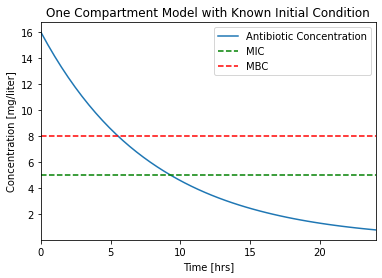

In [37]:
def plotConcentration(soln):
    fig, ax = plt.subplots(1, 1)
    ax.plot(soln.t, soln.y[0])
    ax.set_xlim(0,max(t))
    ax.plot(ax.get_xlim(), [MIC, MIC], 'g--', ax.get_xlim(), [MBC, MBC], 'r--')
    ax.legend(['Antibiotic Concentration','MIC','MBC'])
    ax.set_xlabel('Time [hrs]')
    ax.set_ylabel('Concentration [mg/liter]')
    ax.set_title('One Compartment Model with Known Initial Condition');
    
plotConcentration(soln)

# save solution to a file for reuse in documents and reports
plt.savefig('./figures/Pharmaockinetics1.png')

#### 2.1.3.1.6 Step 5. Analysis of the Results

Let's compare our results to a typical experimental result. 

| | |
| :-: | :-: |
|![](./figures/Pharmaockinetics1.png)|![](figures/nihms-475924-f0001.jpg)|

We see that that the assumption of a fixed initial condition is questionable. Can we fix this?

[Levison, Matthew E., and Julie H. Levison. “Pharmacokinetics and Pharmacodynamics of Antibacterial Agents.” Infectious disease clinics of North America 23.4 (2009): 791–vii. PMC. Web. 8 May 2017.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3675903/)

### 2.1.3.2 Example 2: Improving Simulation using Time-Dependent Input

For the next simulation we will assume the dosing takes place over a short period of time $\delta t$. To obtain a total dose $U_{dose}$ in a time period $\delta t$, the mass flow rate rate must be

$$u(t) = 
\begin{cases}
U/ \delta t \qquad \mbox{for } 0 \leq t \leq \delta t \\
0 \qquad \mbox{for } t \geq \delta t
\end{cases}
$$

Before doing a simulation, we will write a Python function for $u(t)$. 

In [47]:
# parameter values
dt = 1.5         # length hours
Udose = 64       # mg

# function defintion
def u(t):
    if t <= 0:
        return 0
    elif t <= dt:
        return Udose/dt
    else:
        return 0

This code cell demonstrates the use of a list comprehension to apply a function to each value in a list.

Text(0.5, 1.0, 'Dosing function u(t) for of total dose 64 mg')

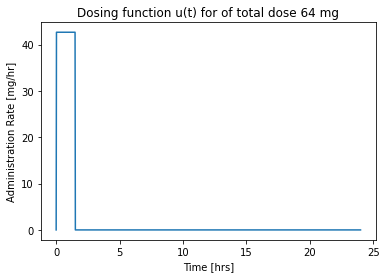

In [48]:
# visualization
t = np.linspace(0, 24, 1000)              # create a list of time steps
y = np.array([u(tau) for tau in t])       # list comprehension

fig, ax = plt.subplots(1, 1)
ax.plot(t, y)
ax.set_xlabel('Time [hrs]')
ax.set_ylabel('Administration Rate [mg/hr]')
ax.set_title('Dosing function u(t) for of total dose {0} mg'.format(Udose))

Simulation

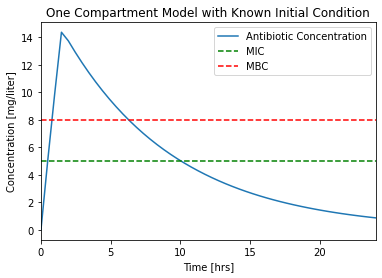

In [46]:
# specify time span and evaluation points
t_span = [0, 24]
t_eval = np.linspace(0, 24, 50)

# initial conditions
C_initial = 0
IC = [C_initial]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval)

# display solution
plotConcentration(soln)
plt.savefig('./figures/Pharmaockinetics2.png')

#### 2.1.3.2.1 Analysis of the Results

Let's compare our results to a typical experimental result. 

| | |
| :-: | :-: |
|![](./figures/Pharmaockinetics2.png)|![](./figures/nihms-475924-f0001.jpg)|

While it isn't perfect, this is a closer facsimile of actual physiological response.

[Levison, Matthew E., and Julie H. Levison. “Pharmacokinetics and Pharmacodynamics of Antibacterial Agents.” Infectious disease clinics of North America 23.4 (2009): 791–vii. PMC. Web. 8 May 2017.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3675903/)

### 2.1.3.3 Example 2: Periodic Dosng

The minimum inhibitory concentration (MIC) of a particular organism to a particular antibiotic is 5 mg/liter, the minimum bactricidal concentration (MBC) is 8 mg/liter. Assume the plasma volume $V$ is 4 liters with a clearance rate $Q$ of 0.5 liters/hour. 

Design an antibiotic therapy to keep the plasma concentration above the MIC level for a period of 96 hours. 

#### 2.1.3.3.1 Solution

We consider the case of repetitive dosing where a new dose is administered every $t_{dose}$ hours. A simple Python "trick" for this calculation is the `%` operator which returns the remainder following division. This is a useful tool worth remembering whenever you need to functions that repeat in time.

In [76]:
# parameter values
td = 2           # length of administration for a single dose
tdose = 8        # time between doses
Udose = 42       # mg

# function defintion
def u(t):
    if t <= 0:
        return 0
    elif t % tdose <= dt:
        return Udose/td
    else:
        return 0

Text(0.5, 1.0, 'Dosing function u(t) for of total dose 42 mg')

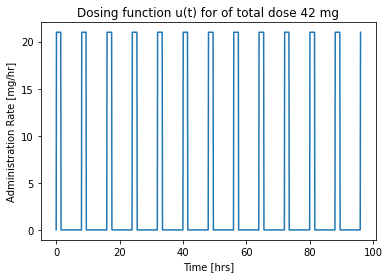

In [77]:
# visualization
t = np.linspace(0, 96, 1000)              # create a list of time steps
y = np.array([u(tau) for tau in t])       # list comprehension

fig, ax = plt.subplots(1, 1)
ax.plot(t, y)
ax.set_xlabel('Time [hrs]')
ax.set_ylabel('Administration Rate [mg/hr]')
ax.set_title('Dosing function u(t) for of total dose {0} mg'.format(Udose))

The dosing function $u(t)$ is now applied to the simulation of drug concentration in the blood plasma. A fourth argument is added to `odeint(deriv, Cinitial, t, tcrit=t)` indicating that special care must be used for every time step. This is needed in order to get a high fidelity simulation that accounts for the rapidly varying values of $u(t)$.

None


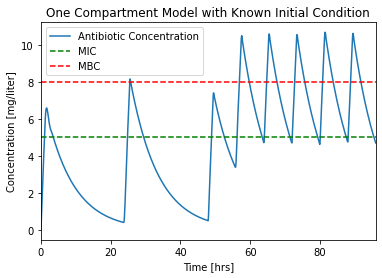

In [81]:
# specify time span and evaluation points
t_span = [0, 96]
t_eval = np.linspace(0, 96, 1000)

# initial conditions
C_initial = 0
IC = [C_initial]

def mbc_crossing(t, y):
    return MBC - y[0]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval)

# display solution
plotConcentration(soln)
plt.savefig('./figures/Pharmaockinetics2.png')

print(soln.t_events)

This looks like a mess, and makes no sense. The problem here is that the solver may be using time steps that are larger than the dosing interval, and missing important changes in the input. The fix to this problem is to specify a `max_step` option for the solver. As a rule of thumb, your simulations should always specify a `max_step` that is smaller than the minimum feature in the input sequence. 

None


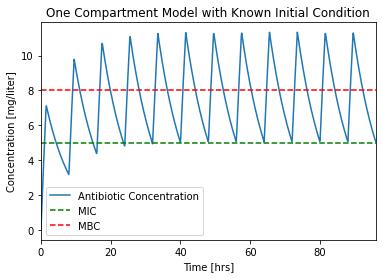

In [82]:
# specify time span and evaluation points
t_span = [0, 96]
t_eval = np.linspace(0, 96, 1000)

# initial conditions
C_initial = 0
IC = [C_initial]

def mbc_crossing(t, y):
    return MBC - y[0]

# compute solution
soln = solve_ivp(deriv, t_span, IC, t_eval=t_eval, max_step=0.1)

# display solution
plotConcentration(soln)
plt.savefig('./figures/Pharmaockinetics2.png')

print(soln.t_events)

## 2.1.4 Analysis

# 2.1 Exercise 1

The purpose of the dosing regime is to maintain the plasma concentration above the MBC level for at least 96 hours. Assuming that each dose is 64 mg, modify the simulation and find a value of $t_{dose}$ that results satisfies the MBC objective for a 96 hour period.  Show a plot concentration versus time, and include Python code to compute the total amount of antibiotic administered for the whole treatment.

# 2.1 Exercise 2

Consider a continous antibiotic injection at a constant rate designed to maintain the plasma concentration at minimum bactricidal level. Your solution should proceed in three steps:

1. First, by hand, set up and solve the steady state equation to find the desired constant dosage rate. 
2. Modify the Python function for $u(t)$ to simulate the desired flowrate.
3. Verify your result by repeating the above simulation using your function for $u(t)$. 

<!--NAVIGATION-->
< [2.0 Process Modeling](https://jckantor.github.io/cbe30338-2021/02.00-Process-Modeling.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.2 Gravity Drained Tank](https://jckantor.github.io/cbe30338-2021/02.02-Gravity-Drained-Tank.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.01-One-Compartment-Pharmacokinetics.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.01-One-Compartment-Pharmacokinetics.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>